# Batch analysis across mice & regions

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from interpolators import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Parameters

In [3]:
# Mouse line
mouseline = 'line3'
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = 5  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Load data

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
baseline_str = f'w{baseline_wlen:.1f}s' if baseline_wlen is not None else ''
postpro_str = f'{baseline_str}_q{baseline_quantile:.2f}'
si = StackInterpolator(order=0, npast=2)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, postpro_str, kd.code, si.code, mouseline)
logger.info(f'loading data from {trialavg_dir}:')
data = load_mousereg_datasets(trialavg_dir)
timeseries = data['timeseries']
stats = data['stats']
stats

 24/05/2022 16:38:41: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w5.0s_q0.08/kd_G0.5_V0.05_npad10/si_order0_npast2/line3:
 24/05/2022 16:38:41: loading timeseries data from timeseries_mouse1_region1.csv
 24/05/2022 16:38:42: loading timeseries data from timeseries_mouse1_region2.csv
 24/05/2022 16:38:42: loading timeseries data from timeseries_mouse6_region1.csv
 24/05/2022 16:38:43: loading timeseries data from timeseries_mouse6_region2.csv
 24/05/2022 16:38:44: loading timeseries data from timeseries_mouse7_region1.csv
 24/05/2022 16:38:44: loading timeseries data from timeseries_mouse7_region2.csv
 24/05/2022 16:38:45: loading timeseries data from timeseries_mouse9_region1.csv
 24/05/2022 16:38:46: loading timeseries data from timeseries_mouse9_region2.csv
 24/05/2022 16:38:46: loading timeseries data from timeseries_mouse10_region1.csv
 24/05/2022 16:38:46: loading timeseries data from timeseries_mouse12_region1.csv
 24/05/2022 16:38:48: loading stats data

line  trial_length  duration (s)   fps  P (MPa)  \
mouse_reg       ROI run                                                     
mouse10_region1 0   0    line3         100.0           0.2  3.56     0.00   
                    1    line3         100.0           0.2  3.56     0.10   
                    2    line3         100.0           0.2  3.56     0.20   
                    3    line3         100.0           0.2  3.56     0.40   
                    4    line3         100.0           0.2  3.56     0.05   
...                        ...           ...           ...   ...      ...   
mouse9_region2  690 10   line3         100.0           0.2  3.56     0.80   
                    11   line3         100.0           0.2  3.56     0.80   
                    12   line3         100.0           0.2  3.56     0.80   
                    13   line3         100.0           0.2  3.56     0.80   
                    14   line3         100.0           0.2  3.56     0.80   

                         DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
mouse_reg       ROI run                                                   
mouse10_region1 0   0      50.0   833.0        0.000000        0.000000   
                    1      50.0   831.0        0.309132        0.154566   
                    2      50.0   830.0        1.236530        0.618265   
                    3      50.0   829.0        4.946119        2.473059   
                    4      50.0   832.0        0.077283        0.038642   
...                         ...     ...             ...             ...   
mouse9_region2  690 10     40.0   903.0       19.784475        7.913790   
                    11     50.0   902.0       19.784475        9.892238   
                    12     60.0   908.0       19.784475       11.870685   
                    13     70.0   909.0       19.784475       13.849133   
                    14     80.0   910.0       19.784475       15.827580   

                         peak displacement velocity (um/s)  ...  \
mouse_reg       ROI run                                     ...   
mouse10_region1 0   0                             0.239623  ...   
                    1                             0.310253  ...   
                    2                             0.239767  ...   
                    3                             0.212660  ...   
                    4                             0.235659  ...   
...                                                    ...  ...   
mouse9_region2  690 10                            0.396873  ...   
                    11                            0.398805  ...   
                    12                            0.370035  ...   
                    13                            0.347023  ...   
                    14                            0.547247  ...   

                         post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) pval  \
mouse_reg       ROI run                                                        
mouse10_region1 0   0                                             0.017342     
                    1                                             0.004588     
                    2                                             0.348739     
                    3                                             0.541310     
                    4                                             0.833705     
...                                                                    ...     
mouse9_region2  690 10                                            0.982767     
                    11                                            0.749557     
                    12                                            0.007235     
                    13                                            0.098755     
                    14                                            0.509002     

                         response type  negative  positive  weak  \
mouse_reg       ROI run                                            

### Breakdown per mouse region

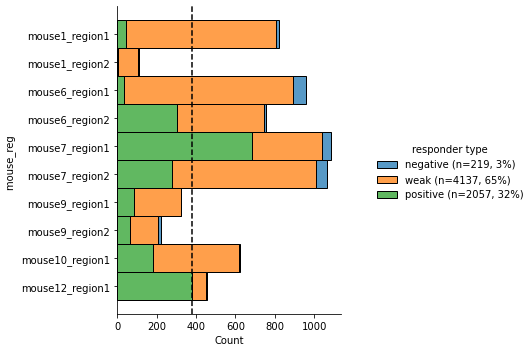

In [5]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

### Exclude datasets with low cell count

 24/05/2022 16:39:14: excluding ['mouse1_region2', 'mouse9_region2', 'mouse9_region1'] datasets from analysis


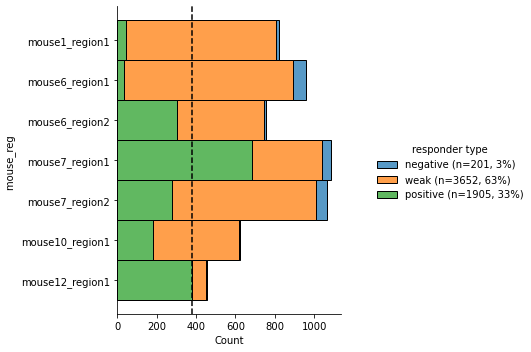

In [6]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.MOUSEREG, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.MOUSEREG).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count)

### Parameter dependency curves

 24/05/2022 16:39:15: sub-indexing data...
 24/05/2022 16:39:15: filtering data...
 24/05/2022 16:39:15: cross-checking filters...
 24/05/2022 16:39:15: grouping by responder type, grouping by mouse_reg, averaging and plotting mean diff Z(ΔF/F0) vs. P (MPa) ...
 24/05/2022 16:39:16: sub-indexing data...
 24/05/2022 16:39:16: filtering data...
 24/05/2022 16:39:16: cross-checking filters...
 24/05/2022 16:39:16: grouping by responder type, grouping by mouse_reg, averaging and plotting mean diff Z(ΔF/F0) vs. DC (%) ...


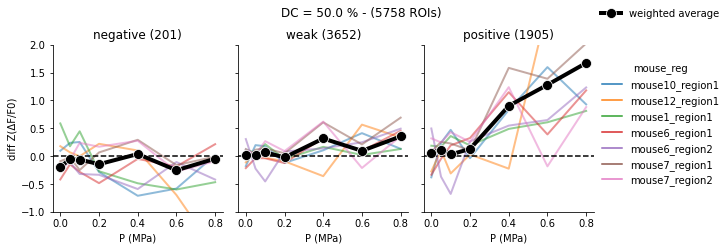

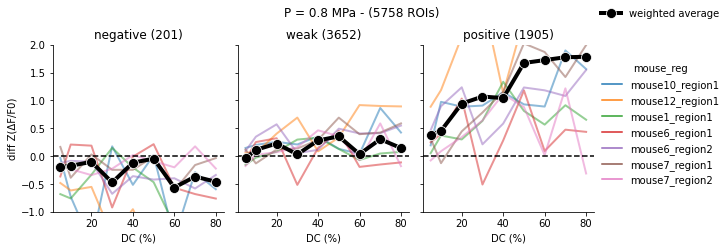

In [7]:
for pkey in [Label.P, Label.DC]:
    figs[f'{pkey}-dep {ykey_postpro}'] = plot_parameter_dependency_across_datasets(
        stats, pkey, ykey_postpro)

### Get plot-ready traces dataset

In [8]:
plt_data = get_plot_data(timeseries, stats)

 24/05/2022 16:39:17: merging timeseries and stats information...
 24/05/2022 16:39:52: adding time info to table...


### Pressure-dependent response traces

 24/05/2022 16:40:00: plotting P (MPa) dependency curves for negative responders...
 24/05/2022 16:40:01: sub-indexing data...
 24/05/2022 16:40:01: filtering data...
 24/05/2022 16:40:01: cross-checking filters...
 24/05/2022 16:40:01: grouping by mouse_reg, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 24/05/2022 16:40:03: plotting P (MPa) dependency curves for positive responders...
 24/05/2022 16:40:03: sub-indexing data...
 24/05/2022 16:40:04: filtering data...
 24/05/2022 16:40:05: cross-checking filters...
 24/05/2022 16:40:05: grouping by mouse_reg, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 24/05/2022 16:40:16: plotting P (MPa) dependency curves for weak responders...
 24/05/2022 16:40:18: sub-indexing data...
 24/05/2022 16:40:20: filtering data...
 24/05/2022 16:40:21: cross-checking filters...
 24/05/2022 16:40:22: grouping by mouse_reg, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...


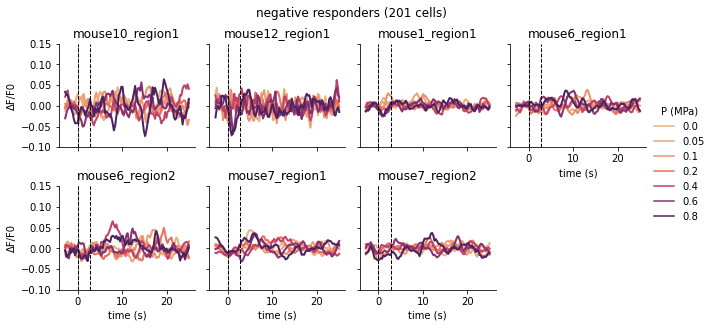

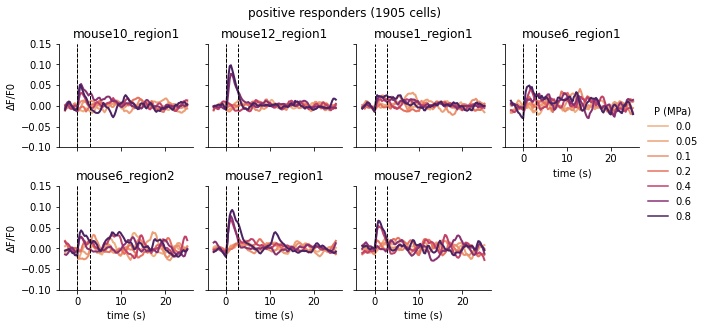

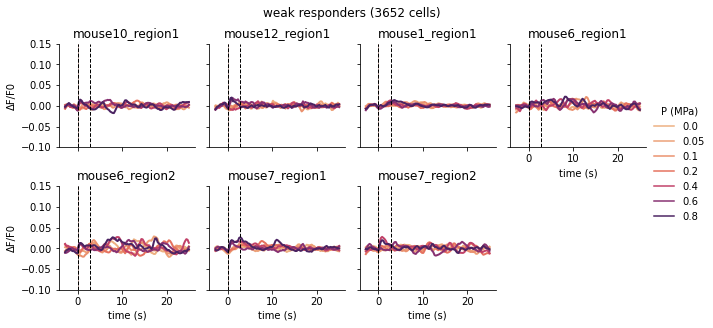

In [9]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=Label.DFF, pkey=Label.P))

### DC-dependent response traces

 24/05/2022 16:40:47: plotting DC (%) dependency curves for negative responders...
 24/05/2022 16:40:47: sub-indexing data...
 24/05/2022 16:40:47: filtering data...
 24/05/2022 16:40:47: cross-checking filters...
 24/05/2022 16:40:47: grouping by mouse_reg, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 24/05/2022 16:40:49: plotting DC (%) dependency curves for positive responders...
 24/05/2022 16:40:50: sub-indexing data...
 24/05/2022 16:40:50: filtering data...
 24/05/2022 16:40:51: cross-checking filters...
 24/05/2022 16:40:52: grouping by mouse_reg, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 24/05/2022 16:41:07: plotting DC (%) dependency curves for weak responders...
 24/05/2022 16:41:09: sub-indexing data...
 24/05/2022 16:41:11: filtering data...
 24/05/2022 16:41:12: cross-checking filters...
 24/05/2022 16:41:14: grouping by mouse_reg, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


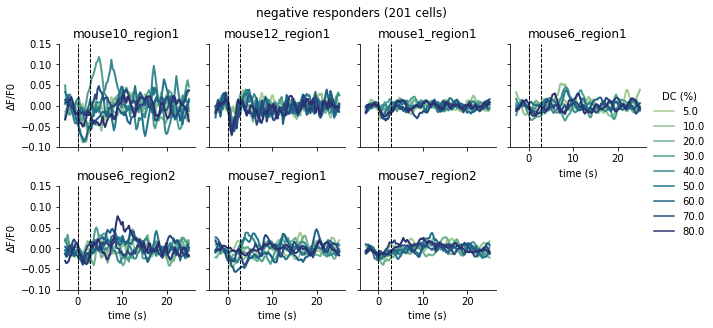

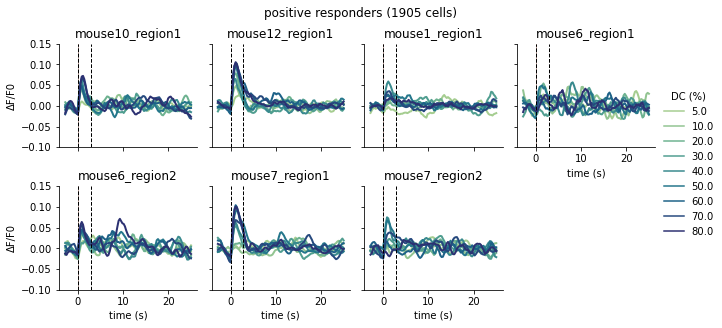

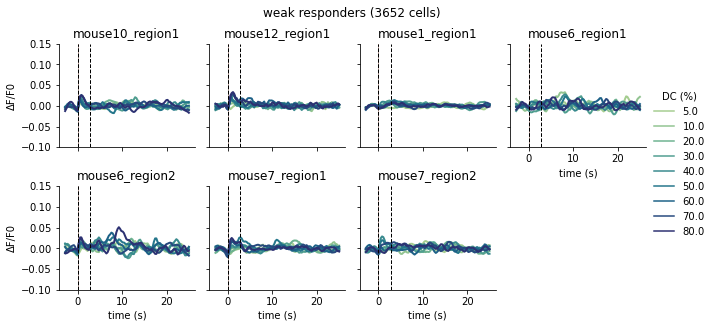

In [10]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=Label.DFF, pkey=Label.DC))

In [13]:
# Copy data and remove run index
avg_plt_data = plt_data.copy().droplevel(Label.RUN)
# Generate new run index from (P, DC) combination 
tmp1 = avg_plt_data[Label.P].map('{:.2f}MPa'.format)
tmp2 = avg_plt_data[Label.DC].map('{:.0f}%DC'.format)
avg_plt_data[Label.RUN] = tmp1 + tmp2
avg_plt_data.set_index(Label.RUN, append=True, inplace=True)
# Group data by mouse-region, response type, run and frame -> average
avg_plt_data = avg_plt_data.groupby(
    [Label.MOUSEREG, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR])

In [14]:
avg_plt_data2 = avg_plt_data.loc[:, [
    Label.P,
    Label.DC,
    Label.DUR,
    Label.TIME,
    Label.DFF,
    Label.ZSCORE
]]
avg_plt_data2

P (MPa)  DC (%)  \
mouse_reg       response type  run          frame                    
mouse10_region1 non-responsive 0.00MPa50%DC 0          0.0    50.0   
                                            1          0.0    50.0   
                                            2          0.0    50.0   
                                            3          0.0    50.0   
                                            4          0.0    50.0   
...                                                    ...     ...   
mouse7_region2  responsive     0.80MPa80%DC 95         0.8    80.0   
                                            96         0.8    80.0   
                                            97         0.8    80.0   
                                            98         0.8    80.0   
                                            99         0.8    80.0   

                                                   duration (s)   time (s)  \
mouse_reg       response type  run          frame                            
mouse10_region1 non-responsive 0.00MPa50%DC 0               0.2  -2.808989   
                                            1               0.2  -2.528090   
                                            2               0.2  -2.247191   
                                            3               0.2  -1.966292   
                                            4               0.2  -1.685393   
...                                                         ...        ...   
mouse7_region2  responsive     0.80MPa80%DC 95              0.2  23.876404   
                                            96              0.2  24.157303   
                                            97              0.2  24.438202   
                                            98              0.2  24.719101   
                                            99              0.2  25.000000   

                                                      ΔF/F0  Z(ΔF/F0)  
mouse_reg       response type  run          frame                      
mouse10_region1 non-responsive 0.00MPa50%DC 0      0.105361 -0.013989  
                                            1      0.111344  0.306578  
                                            2      0.116318  0.589472  
                                            3      0.115157  0.550136  
                                            4      0.111835  0.386943  
...                                                     ...       ...  
mouse7_region2  responsive     0.80MPa80%DC 95     0.187705  2.819680  
                                            96     0.189841  2.862763  
                                            97     0.188244  2.777900  
                                            98     0.182922  2.649863  
                                            99     0.177301  2.421448  

[21000 rows x 6 columns]

 17/05/2022 16:48:59: sub-indexing data...
 17/05/2022 16:48:59: filtering data...
 17/05/2022 16:48:59: cross-checking filters...
 17/05/2022 16:48:59: grouping by response type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


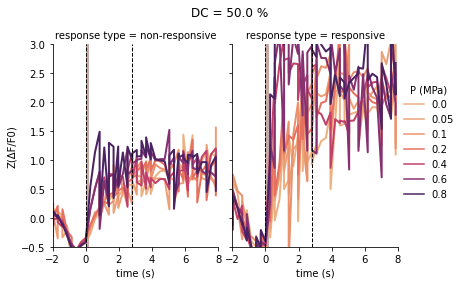

In [15]:
tracekwargs = dict(
    tbounds = [-2, 8.],  # s
    ybounds = {
        Label.ZSCORE: [-.5, 3.],
        Label.DFF: [0, .25]
        }[ykey],   # y-axis unit
    height = 4,  # height of each figure axis
    aspect = 0.7,  # width / height aspect ratio of each axis
)

# Pressure dependency
figs[f'responses {ykey} by type DC={DC_REF}%'] = plot_responses(
    avg_plt_data2, ykey=ykey, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, ci=None, **tracekwargs)
    # # Duty cycle dependency
    # figs[f'responses {ykey} by type P={P_REF}MPa'] = plot_responses(
    #     plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
    #     col=Label.ROI_RESP_TYPE, **tracekwargs)

### Save figures

In [12]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=mouseline)

 24/05/2022 16:47:33: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.05.24/figs_line3.pdf:


100%|██████████| 9/9 [00:01<00:00,  5.11it/s]
